In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("/root/clip")
import random

import torch
import matplotlib.pyplot as plt

from clipmbt.data import load_data, CollateNoncontrastive, Collate_Constrastive
from clipmbt.datasets import enterface, asvp, librispeech, iemocap, tess
from clipmbt.augment.specaugment import Specaugment

In [3]:
def gen_maskid_frame(sequence_len, mask_size):
    mask_id = random.sample(range(0, sequence_len), mask_size)
    return torch.tensor(mask_id)
    

def gen_maskid_freq(sequence_len, mask_size, upper_half=False):
    if upper_half:
        range_start = 0
        range_end = sequence_len // 2
    else:
        range_start = sequence_len // 2
        range_end = sequence_len

    mask_id = random.sample(range(range_start, range_end), mask_size)
    return torch.tensor(mask_id)
    

def display_masked_batch(x, mask_strategy, num_patches, mask_patches):
    B = x.shape[0]
    mask_dense = torch.ones([x.shape[0], x.shape[1], x.shape[2]], device=x.device)

    # for each audio clip in the batch
    for i in range(B):
        mask_index = torch.empty((B, mask_patches), device=x.device, requires_grad=False).long()
        # use this if you are masking frame, i.e., 128*2 patches
        mask_index[i] = mask_strategy(num_patches, mask_patches)
        # mask the encode samples with 0
        # mask_dense[i, mask_index[i], :] = 0
        mask_dense[i, :, mask_index[i]] = 0


    # mask the patch
    x = x * mask_dense

    plt.imshow(x.permute(0, 2, 1).cpu()[0], cmap=plt.cm.binary)

    
def display_specaugment_batch(x):
    s = Specaugment(tmask_param=40, fmask_param=40)
    # x = s(x)
    print(x.shape, x.dtype)
    plt.imshow(x.permute(0, 2, 1).cpu()[0], cmap=plt.cm.binary)
    plt.show()

In [16]:
dataset_to_use = tess

aug = Specaugment(tmask_param=20, fmask_param=20)
# train_collate_func = CollateNoncontrastive(dataset_to_use, augmentor=None)
train_collate_func = Collate_Constrastive(dataset_to_use, augmentor=aug)
train_dl, _, _, split_seed  = load_data(dataset_to_use, 
                                    batch_sz=3,
                                    train_val_test_split=[1.0, 0.0, 0.0],
                                    train_collate_func=train_collate_func,
                                    nlines=3,
                                    modalites=["audio"],
                                    val_collate_func=None)


torch.Size([3, 200, 128]) torch.float32


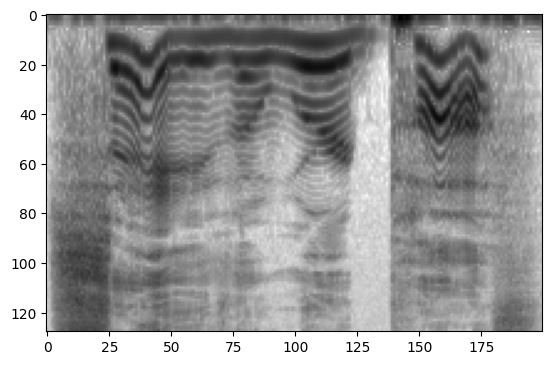

torch.Size([3, 200, 128]) torch.float32


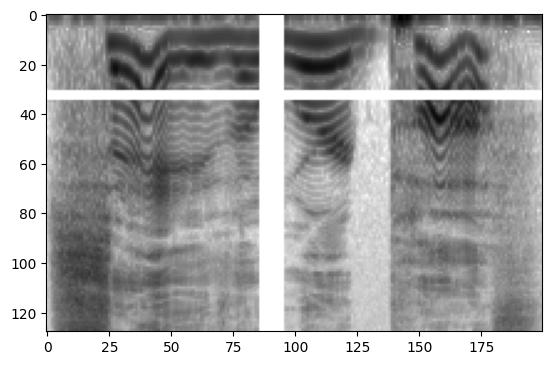

tensor(False) tensor(False)
tensor([[[0.5353, 0.5321, 0.4240,  ..., 0.1505, 0.2304, 0.2454],
         [0.6246, 0.6240, 0.6093,  ..., 0.2571, 0.2179, 0.2226],
         [0.6480, 0.6470, 0.6263,  ..., 0.3829, 0.3543, 0.2981],
         ...,
         [0.7639, 0.7630, 0.7438,  ..., 0.4063, 0.4123, 0.4120],
         [0.7660, 0.7652, 0.7475,  ..., 0.3734, 0.3649, 0.3685],
         [0.7305, 0.7301, 0.7173,  ..., 0.3118, 0.3241, 0.3256]],

        [[0.6141, 0.6107, 0.4890,  ..., 0.2086, 0.1664, 0.2215],
         [0.7280, 0.7277, 0.7169,  ..., 0.2385, 0.2043, 0.2466],
         [0.7294, 0.7289, 0.7146,  ..., 0.3279, 0.2625, 0.3489],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.5273, 0.5248, 0.4661,  ..., 0.2151, 0.2250, 0.2121],
         [0.5958, 0.5953, 0.5813,  ..., 0.2327, 0.2521, 0.2627],
         [0.6200, 0.6191, 0.59

In [21]:
data = next(iter(train_dl))
_, spec_batch1 = data["clip0"]
_, spec_batch2 = data["clip1"]
# display_masked_batch(spec_batch, gen_maskid_freq, 128, 20)
display_specaugment_batch(spec_batch1)
display_specaugment_batch(spec_batch2)
print(torch.isnan(spec_batch1).any(), torch.isnan(spec_batch2).any())
print(spec_batch1)

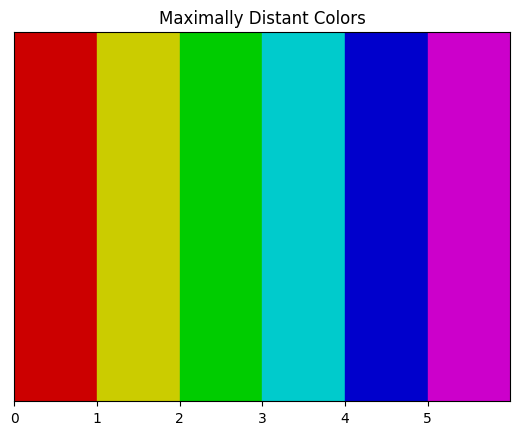

In [6]:
import colorsys

def get_label_colours(n: int):
    colors = []
    hue_step = 360.0 / n

    for i in range(n):
        hue = i * hue_step
        saturation = 1  # You can adjust saturation and lightness if needed
        lightness = 0.4   # You can adjust saturation and lightness if needed

        rgb = colorsys.hls_to_rgb(hue / 360.0, lightness, saturation)
        hexcol = "#" + "".join([f"{int(v * 255):02X}" for v in rgb])
        colors.append(hexcol)

    return colors

num_colors =  6
max_distant_colors = get_label_colours(num_colors)
# Display colors using matplotlib
fig, ax = plt.subplots()
for i, color in enumerate(max_distant_colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
ax.set_xlim(0, num_colors)
ax.set_ylim(0, 1)
ax.set_xticks(range(num_colors))
ax.set_yticks([])
ax.set_title("Maximally Distant Colors")
plt.show()